In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import hamming_loss, accuracy_score
from scipy.sparse import hstack
from sklearn.metrics import jaccard_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain
from nltk.stem import PorterStemmer, SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

# Data Cleaning and Preparation

In [ ]:
np.random.seed(seed=11)
df_questions = pd.read_csv("Questions.csv", encoding="ISO-8859-1")
df_tags = pd.read_csv("Tags.csv", encoding="ISO-8859-1")

In [ ]:
df_questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
# Drop useless columns
df_questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [ ]:
df_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [ ]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Id      1264216 non-null  int64 
 1   Score   1264216 non-null  int64 
 2   Title   1264216 non-null  object
 3   Body    1264216 non-null  object
dtypes: int64(2), object(2)
memory usage: 38.6+ MB


In [ ]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [ ]:
# Grouping the tags by id:
df_tags['Tag'] = df_tags['Tag'].astype(str)
grouped_tags = df_tags.groupby("Id")['Tag'].apply(lambda x: ' '.join(x))
grouped_tags.reset_index()


,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [ ]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags_final.head()

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [ ]:
# Finally mapping the tags to the questions by id:
df = df_questions.merge(grouped_tags_final, on = "Id")
df.head()

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [ ]:
# Filter by score with a threshold of 5
print(f"Mean Score   : {df['Score'].mean()}")
print(f"Minimum Score: {df['Score'].min()}")
print(f"Maximum Score: {df['Score'].max()}")
df = df[df['Score'] > 5]

Mean Score   : 1.781537332228037
Minimum Score: -73
Maximum Score: 5190


In [ ]:
df.head()

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [ ]:
# Removing columns that are no longer required:
df.drop(columns= ['Id', 'Score'], inplace=True)
df.drop_duplicates(inplace = True)

df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [ ]:
# Getting unique tags:
df['Tags'] = df['Tags'].apply(lambda x: x.split())

# All tags
all_tags = [item for sublist in df['Tags'].values for item in sublist]
print(len(all_tags))

# Unique Tags
unique_tags = list(set(all_tags))
print(len(unique_tags))

224129
14883


In [ ]:
keywords = nltk.FreqDist(all_tags)
frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]
print(len(tags_features))
tags_features

100


['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

In [ ]:
# Function to filter most common tags
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [ ]:
# Apply filter and fill empty cells with none:
df['Tags'] = df['Tags'].apply(lambda x: most_common(x))
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)


In [ ]:
df.shape

(72950, 3)

In [ ]:
# Drop records with no tags after filteration:
df.dropna(subset=['Tags'], inplace=True)
df.shape

(63167, 3)

In [ ]:
# Get Text and remove HTML tags:
df['Body'] = df['Body'].apply(lambda x: BeautifulSoup(x).get_text())
df.head()

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...,"[sql, asp.net]"
3,Function for creating color wheels,This is something I've pseudo-solved many time...,[algorithm]
4,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,"[c#, .net]"
5,Should I use nested classes in this case?,I am working on a collection of classes used f...,"[c++, oop, class]"


In [ ]:
df.to_csv('TaggedQuestions.csv')

# NLP Preprocessing

In [ ]:
def stem_tokens(tokens, usePOS: bool = False, stemmer = PorterStemmer()):
    stemmed_tokens = []
    if usePOS:
        # Tag tokens with POS
        tagged_tokens = pos_tag(tokens)

        # Perform stemming based on POS (You can remove POS and use normal stemming to make it less computationally expensive)
        
        for token, pos in tagged_tokens:
            if pos.startswith('NN'):  # noun
                stemmed_token = stemmer.stem(token)
            elif pos.startswith('VB'):  # verb
                stemmed_token = stemmer.stem(token)
            elif pos.startswith('JJ'):  # adjective
                stemmed_token = stemmer.stem(token)
            else:
                stemmed_token = stemmer.stem(token)
            stemmed_tokens.append(stemmed_token)
    else:
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

In [ ]:
def lemmatize_tokens(tokens, usePOS: bool = False, lemmatizer = WordNetLemmatizer()):
    lemmatized_tokens = []
    
    if usePOS:
        # Tag tokens with POS
        tagged_tokens = pos_tag(tokens)

        # Lemmatize tokens based on POS (You can remove POS and use normal lemmatization to make it less computationally expensive)
        
        for token, pos in tagged_tokens:
            if pos.startswith('NN'):  # noun
                lemmatized_token = lemmatizer.lemmatize(token, pos='n')
            elif pos.startswith('VB'):  # verb
                lemmatized_token = lemmatizer.lemmatize(token, pos='v')
            elif pos.startswith('JJ'):  # adjective
                lemmatized_token = lemmatizer.lemmatize(token, pos='a')
            else:
                lemmatized_token = lemmatizer.lemmatize(token)
            lemmatized_tokens.append(lemmatized_token)
    else:
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [ ]:
def nlp_pipeline(text, tokenizer=ToktokTokenizer()):
    # Prepare stop words
    stop_words = set(stopwords.words('english'))

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Stem / Lemmatize
    filtered_tokens = stem_tokens(filtered_tokens)

    # Rejoin tokens into a string
    return ' '.join(filtered_tokens)

In [ ]:
# Apply pipeline to the two text columns:

df['Body'] = df['Body'].apply(nlp_pipeline)
df['Title'] = df['Title'].apply(nlp_pipeline)
df.head()
df.to_csv('Preprocessed.csv')

# Model Creation, Evaluation and Visualization

In [ ]:
# Extracting features and target variable:
X1 = df['Body']
X2 = df['Title']
y = df['Tags']

In [ ]:
# Putting tags in numerical form:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)
# Save using pickle
with open("multilabel_binarizer.pkl", 'wb') as f:
    pickle.dump(multilabel_binarizer, f)

In [ ]:
# Feature extraction on body and title fields using TFIDF:
vectorizer_X1 = TfidfVectorizer()

vectorizer_X2 = TfidfVectorizer()

In [ ]:
# Vectorize fields:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

# Save using pickle
with open("vectorizer_X1.pkl", 'wb') as f:
    pickle.dump(X1_tfidf, f)

with open("vectorizer_X2.pkl", 'wb') as f:
    pickle.dump(X2_tfidf, f)

In [ ]:
# Combine into one:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 41) # 80% - 20% train test split

In [ ]:
# Prints Accuracy, Hamming loss and Jaccard score:
def evaluate_model(y_pred, model_name):
    hl = hamming_loss(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    score = jaccard_score(y_test, y_pred, average='weighted')

    print("Classifier Used:", model_name)
    print(f'Hamming loss: {hl:.4f}')
    print(f'Accuracy score: {acc:.4f}')
    print(f'Jaccard score: {score:.4f}')
    print("\n")

In [ ]:
def visualize_model(y_pred):
    # Get all tags
    tags = list(multilabel_binarizer.classes_)
    
    # Confusion matrix:
    cm = multilabel_confusion_matrix(y_test, y_pred)[0]

    # Plot confusion matrix:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", square=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()

In [ ]:
def visualize_model_full(y_pred):
    # Get all tags
    tags = list(multilabel_binarizer.classes_)
    
    # Get binary values, 0 or 1 from probabilities
    y_pred_binary = np.round(y_pred)
    
    # Confusion Matrix
    confusion_matrix = tf.math.confusion_matrix(labels = y_test.argmax(axis = 1), predictions = y_pred_binary.argmax(axis = 1)).numpy()
    
    confusion_matrix_normalized = confusion_matrix / confusion_matrix.sum(axis = 0)
    
    # Plot confusion matrix:
    plt.figure(figsize=(100, 100))
    sns.heatmap(confusion_matrix_normalized, annot=True, cmap="coolwarm", square=True, xticklabels=tags, yticklabels=tags)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()
    
    

In [ ]:
def tag_heatmap(y_pred):
    # Create a binary matrix indicating the presence or absence of each tag
    pred_matrix = np.array(y_pred)
    true_matrix = np.array(y_test)
    
    # Compute the confusion matrix between predicted and true labels
    confusion_matrix = np.dot(pred_matrix.T, true_matrix)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='coolwarm')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Tag Heatmap')
    plt.show()

Classifier Used: SGDClassifier()
Hamming loss: 0.0099
Accuracy score: 0.3441
Jaccard score: 0.4118




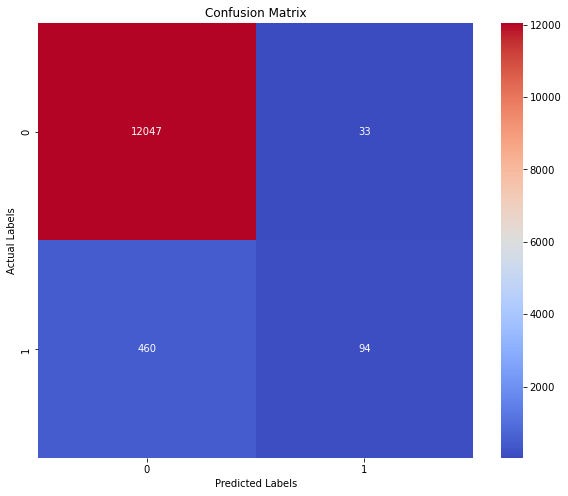

Classifier Used: LinearSVC()
Hamming loss: 0.0094
Accuracy score: 0.3984
Jaccard score: 0.4862




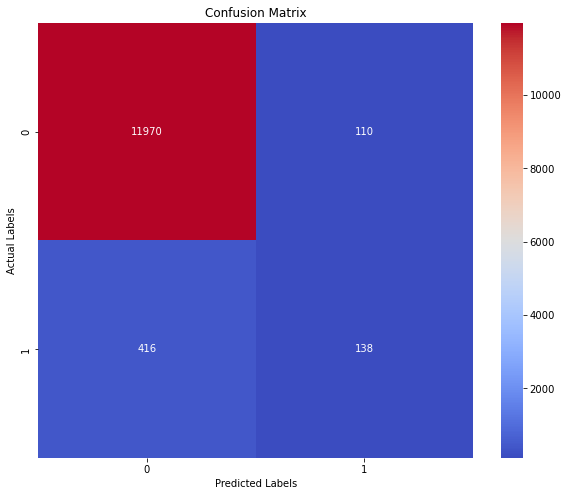

Classifier Used: PassiveAggressiveClassifier()
Hamming loss: 0.0104
Accuracy score: 0.3791
Jaccard score: 0.4735




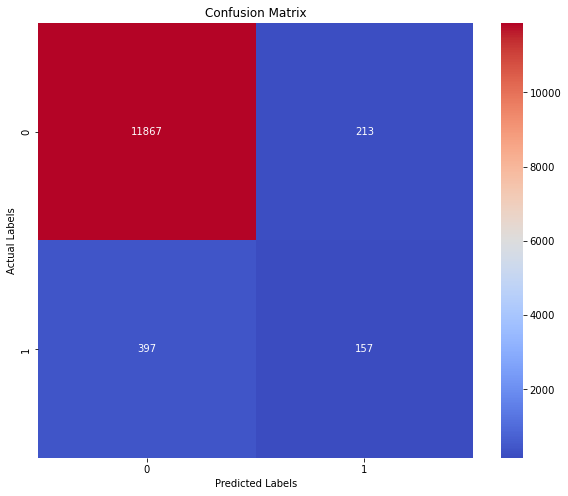

In [ ]:
# Trying different classifications models:
sgd = SGDClassifier()
#lr = LogisticRegression()
svc = LinearSVC()
pac = PassiveAggressiveClassifier()

for classifier in [ sgd, svc, pac]:
    
    clf = ClassifierChain(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    evaluate_model(y_pred, classifier)
    visualize_model(y_pred)
    
     # Save using pickle
    with open("model_" + str(classifier) +".pkl", 'wb') as f:
        pickle.dump(clf, f)

In [ ]:
# Neural network classification model: (Takes too long and not good)
# mlpc = MLPClassifier(max_iter=5000, solver="lbfgs", learning_rate= "adaptive", hidden_layer_sizes=(100,100,100))
# mlpc = MLPClassifier()
# mlpc.fit(X_train, y_train)

# y_pred = mlpc.predict(X_test)
# evaluate_model(y_pred, "mlp")
# visualize_model(y_pred)
#  # Save using pickle
# with open("model_" + str(mlpc) +".pkl", 'wb') as f:
#     pickle.dump(clf, f)

In [ ]:
# A question to try the model on
title = "Tag for images"
body =  '''I was creating a photo gallery website, and I am fairly new to web developement, I was wondering how can I make an image in HTML?
'''

# Perform same pipeline
title = nlp_pipeline(title)
body = nlp_pipeline(body)

# Same vectorizer
X1_tfidf_trial = vectorizer_X1.transform([body])
X2_tfidf_trial = vectorizer_X2.transform([title])

# Combine X features
X_tfidf_trial = hstack([X1_tfidf_trial, X2_tfidf_trial])

# Use any model from the saved ones
model = pickle.load(open('model_LinearSVC().pkl', 'rb'))

# Get prediction (binary format)
predicted_tags_bin = model.predict(X_tfidf_trial)

# Get actual tags by reverse transforming
predicted_tags = multilabel_binarizer.inverse_transform(predicted_tags_bin)
print(predicted_tags)

[('html',)]
